
| Universidad de los Andes<br>Departamento de Ingeniería Eléctrica y Electrónica<br>Machine Learning<br>Ríos Beltrán Manuel Sebastián - Código 201317670<br>Ruiz Ruiz Alison Gissell - Código 202116230<br><br><p style="font-size:30px">Taller 1 - Regresión Lineal: Predicción de Precios de Autos </p> 	||
|-----------------------------------------------------------------------------------	|---	|

Una tarea bastante común en el contexto de Machine Learning es la predicción de una variable según algunos descriptores. En esta ocasión partiremos de un dataset que involucra ocho variables (algunas numéricas, otras categóricas) y el precio de un automóvil, el cual se desea estimar empleando un modelo de regresión lineal.

**Objetivos:**
- Aprender a lidiar con descriptores categóricos no-numéricos.
- Usar la librería Pandas para manejar datos tabulares en formato .csv.
- Emplear la librería Scikit Learn para preprocesamiento y entrenamiento de un modelo de regresión lineal.
- Implementar el algoritmo Descenso de Gradiente Estocástico para un modelo lineal básico.

Inicialmente se importan las librerías necesarias para llevar a cabo el manejo de los datos y los entrenamientos.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from google.colab import drive
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Se importa el archivo con el dataset que se emplea para los entrenamiento y se observa la estructura de este archivo, donde se tienen variables no númericas (modelo, tipo de transmisión y de combustible) y númericas (año, kilometraje, entre otros), donde el target de los modelos a construir consiste en predecir el valor del precio, basado en las demás características, por ende la etiqueta de salida de entrenamiento corresponde a esta etiqueta que se encuentra en la columna 3: price. 

In [2]:
df = pd.read_csv('/content/drive/MyDrive/ML/HW1/carDataset/toyota.csv')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


Para obtener la información del dataset a nivel general, se emplea el comando *df.info()*, donde se conoce que el dataset consta de 6738 filas de datos con las nueve columnas correspondientes a cada variable visualizada en la celda anterior. El dataset posee 3 variables categoricas y 6 numéricas.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


Podemos observar algunas categorías numéricas, y otras de tipo _object_ (string).

In [4]:
categ = ['model','year','transmission','fuelType','engineSize']
str_categ = ['model','transmission','fuelType']
numer = ['price','mileage','tax','mpg']

## Parte 1

A continuación se realiza el ajuste de los datos para un modelo de regresión lineal definido mediante la librería SciKit-Learn. Se observan dos métricas de precisión, en este caso Error Cuadrático Medio (RMSE) y $R^2$.

#### Casos:

- Caso 1: Codificación One-Hot (MinMaxScaler)
- Caso 2: Codificación Ordinal (MinMaxScaler)
- Caso 3: Codificación One-Hot (RobustScaler)
- Caso 4: Codificación Ordinal (RobustScaler)
- Caso 5: Entrenar con un 30% (Codificación Ordinal, MinMaxScaler)
- Caso 6: Entrenar con un 55% (Codificación Ordinal, MinMaxScaler)
- Caso 7: Entrenar con un 80% (Codificación Ordinal, MinMaxScaler)

### Caso 1:
#### Codificación One-Hot  (MinMaxScaler)

Una de las formas de codificar categorías no numéricas se conoce como _One-Hot encoding_, en donde se crea una columna para cada valor distinto que exista en la característica que estamos codificando y, para cada registro, marcar con un 1 la columna a la que pertenezca dicho registro y dejar las demás con 0, convirtiendo una variable categórica en varias variables. Como se observa a continuación, la variable de transmisión se dividió en automática, manual u otra, de la misma manera funciona con las otras dos variables categóricas al aplicar el One-Hot, pasando de tener 9 variables a muchas más, de acuerdo con la cantidad de categorías de cada una.

En este caso se realiza un escalamiento de los datos utilizando un *MinMaxScaler*, el cual resta el valor mínimo de la característica y luego divide por el rango (donde el rango es la diferencia entre el máximo y el mínimo), normalizando los datos para que queden entre 0 y 1 sin modificar la distribución original de los datos, como se evidencia a continuación, efectivamente quedan los rangos de los valores entre 0 y 1.

In [5]:
df_ohe = pd.get_dummies(df)
scaler = MinMaxScaler()
df_scl_ohe = scaler.fit_transform(df_ohe)
df_scl_ohe = pd.DataFrame(df_scl_ohe, columns = df_ohe.columns)
df_scl_ohe.head()

,year,price,mileage,tax,mpg,engineSize,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Camry,model_ Corolla,model_ GT86,model_ Hilux,model_ IQ,model_ Land Cruiser,model_ PROACE VERSO,model_ Prius,model_ RAV4,model_ Supra,model_ Urban Cruiser,model_ Verso,model_ Verso-S,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,0.818182,0.256150,0.138100,0.469027,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.863636,0.256066,0.106716,0.256637,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.772727,0.222301,0.157479,0.469027,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.863636,0.306839,0.084476,0.265487,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.863636,0.281478,0.208019,0.256637,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Separación de Datos

Para entrenar, se requiere separar los label target del resto de información, para ello se crea un dataframe Y con la información de precio y un dataframe X con la demás información. Adicionalmente, se requiere hacer un split de los datos en el conjunto de entrenamiento y de prueba, con el cual se mide el porcentaje de precisión y error a través de las épocas de entrenamiento, en este caso se emplea un 80% del dataset para entrenar y un 20% para test. 

In [6]:
X = df_scl_ohe.drop(['price'], axis=1)
y = df_scl_ohe['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

Se crea el modelo de regresión lineal de sklearn, se entrena y se calcula el Error Cuadrado $R^2$ y Error Cuadrático Medio (RMSE) para evaluar el comportamiento del modelo.

In [7]:
model_1 = LinearRegression()

model_1.fit(X_train, y_train)
preds = model_1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rs = model_1.score(X_test, y_test)
print(f'RMSE: {round(rmse,3)}')
print(f'R^2: {round(rs,3)}\n')

RMSE: 0.031
R^2: 0.917



### Caso 2

#### Codificación Ordinal  (MinMaxScaler)

Otra forma de codificar categorías no numéricas se conoce como _ordinal encoding_, en donde se asigna a cada categoría un valor numérico, como se observa a continuación, las variables de modelo, tipo de transmisión y combustible poseen ahora una variable numérica que no cambia en las primeras cinco filas ya que para estas filas las categorías permanecían iguales entre sí. A diferencia del One-Hot, se mantienen las 9 columnas de variables.

In [8]:
oe = OrdinalEncoder()
df_oe = df.copy()
df_oe[str_categ] = oe.fit_transform(df_oe[str_categ])

x = df_oe.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scl_oe = pd.DataFrame(x_scaled, columns=df_oe.columns)
df_scl_oe.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0.352941,0.818182,0.256150,0.333333,0.138100,1.0,0.469027,0.143842,0.444444
1,0.352941,0.863636,0.256066,0.333333,0.106716,1.0,0.256637,0.143842,0.444444
2,0.352941,0.772727,0.222301,0.333333,0.157479,1.0,0.469027,0.143842,0.444444
3,0.352941,0.863636,0.306839,0.333333,0.084476,1.0,0.265487,0.143842,0.444444
4,0.352941,0.863636,0.281478,0.333333,0.208019,1.0,0.256637,0.143842,0.444444


#### Separación de Datos

In [9]:
X = df_scl_oe.drop(['price'], axis=1)
y = df_scl_oe['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [10]:
model_2 = LinearRegression()

model_2.fit(X_train, y_train)
preds = model_2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rs = model_2.score(X_test, y_test)
print(f'RMSE: {round(rmse,3)}')
print(f'R^2: {round(rs,3)}\n')

RMSE: 0.05
R^2: 0.787



### Caso 3

#### Codificación One-Hot (RobustScaler)

En este caso se emplea el escalamiento de datos RobustScaler, que transforma el vector de datos restando la mediana y dividiendo por el rango intercuartíloco (valor del 75% - valor del 25%), como los datos en este caso obtienen una transformación, ésta reduce importancia a outlayers si estos existen en los datos.

In [11]:
df_ohe = pd.get_dummies(df)
scaler = RobustScaler()
df_rscl_ohe = scaler.fit_transform(df_ohe)
df_rscl_ohe = pd.DataFrame(df_scl_ohe, columns = df_ohe.columns)
df_rscl_ohe.head()

,year,price,mileage,tax,mpg,engineSize,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Camry,model_ Corolla,model_ GT86,model_ Hilux,model_ IQ,model_ Land Cruiser,model_ PROACE VERSO,model_ Prius,model_ RAV4,model_ Supra,model_ Urban Cruiser,model_ Verso,model_ Verso-S,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,0.818182,0.256150,0.138100,0.469027,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.863636,0.256066,0.106716,0.256637,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.772727,0.222301,0.157479,0.469027,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.863636,0.306839,0.084476,0.265487,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.863636,0.281478,0.208019,0.256637,0.143842,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Separación de Datos

In [12]:
X = df_rscl_ohe.drop(['price'], axis=1)
y = df_rscl_ohe['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [13]:
model_3 = LinearRegression()

model_3.fit(X_train, y_train)
preds = model_3.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rs = model_3.score(X_test, y_test)
print(f'RMSE: {round(rmse,3)}')
print(f'R^2: {round(rs,3)}\n')

RMSE: 0.031
R^2: 0.917



### Caso 4

#### Codificación Ordinal (RobustScaler)

In [14]:
oe = OrdinalEncoder()
df_oe = df.copy()
df_oe[str_categ] = oe.fit_transform(df_oe[str_categ])

x = df_oe.values #returns a numpy array
robust_scaler = RobustScaler()
x_scaled = robust_scaler.fit_transform(x)
df_scl_oe = pd.DataFrame(x_scaled, columns=df_oe.columns)
df_scl_oe.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0.066667,-0.5,0.776286,0.0,0.257936,0.0,0.896552,-1.955882,0.625
1,0.066667,0.0,0.775541,0.0,0.004718,0.0,0.068966,-1.955882,0.625
2,0.066667,-1.0,0.477703,0.0,0.414289,0.0,0.896552,-1.955882,0.625
3,0.066667,0.0,1.223415,0.0,-0.174718,0.0,0.103448,-1.955882,0.625
4,0.066667,0.0,0.999702,0.0,0.822056,0.0,0.068966,-1.955882,0.625


#### Separación de Datos

In [15]:
X = df_scl_oe.drop(['price'], axis=1)
y = df_scl_oe['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [16]:
model_4 = LinearRegression()

model_4.fit(X_train, y_train)
preds = model_4.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rs = model_4.score(X_test, y_test)
print(f'RMSE: {round(rmse,3)}')
print(f'R^2: {round(rs,3)}\n')

RMSE: 0.444
R^2: 0.787



### Caso 5

#### Caso 5: Entrenar con un 30% (Codificación Ordinal, MinMaxScaler)

In [17]:
oe = OrdinalEncoder()
df_oe = df.copy()
df_oe[str_categ] = oe.fit_transform(df_oe[str_categ])

x = df_oe.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scl_oe = pd.DataFrame(x_scaled, columns=df_oe.columns)
df_scl_oe.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0.352941,0.818182,0.256150,0.333333,0.138100,1.0,0.469027,0.143842,0.444444
1,0.352941,0.863636,0.256066,0.333333,0.106716,1.0,0.256637,0.143842,0.444444
2,0.352941,0.772727,0.222301,0.333333,0.157479,1.0,0.469027,0.143842,0.444444
3,0.352941,0.863636,0.306839,0.333333,0.084476,1.0,0.265487,0.143842,0.444444
4,0.352941,0.863636,0.281478,0.333333,0.208019,1.0,0.256637,0.143842,0.444444


#### Separación de Datos

In [18]:
X = df_scl_oe.drop(['price'], axis=1)
y = df_scl_oe['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=22)

In [19]:
model_5 = LinearRegression()

model_5.fit(X_train, y_train)
preds = model_5.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rs = model_5.score(X_test, y_test)
print(f'RMSE: {round(rmse,3)}')
print(f'R^2: {round(rs,3)}\n')

RMSE: 0.049
R^2: 0.785



### Caso 6

#### Caso 5: Entrenar con un 55% (Codificación Ordinal, MinMaxScaler)

In [20]:
oe = OrdinalEncoder()
df_oe = df.copy()
df_oe[str_categ] = oe.fit_transform(df_oe[str_categ])

x = df_oe.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scl_oe = pd.DataFrame(x_scaled, columns=df_oe.columns)
df_scl_oe.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0.352941,0.818182,0.256150,0.333333,0.138100,1.0,0.469027,0.143842,0.444444
1,0.352941,0.863636,0.256066,0.333333,0.106716,1.0,0.256637,0.143842,0.444444
2,0.352941,0.772727,0.222301,0.333333,0.157479,1.0,0.469027,0.143842,0.444444
3,0.352941,0.863636,0.306839,0.333333,0.084476,1.0,0.265487,0.143842,0.444444
4,0.352941,0.863636,0.281478,0.333333,0.208019,1.0,0.256637,0.143842,0.444444


#### Separación de Datos

In [21]:
X = df_scl_oe.drop(['price'], axis=1)
y = df_scl_oe['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=22)

In [22]:
model_6 = LinearRegression()

model_6.fit(X_train, y_train)
preds = model_6.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rs = model_6.score(X_test, y_test)
print(f'RMSE: {round(rmse,3)}')
print(f'R^2: {round(rs,3)}\n')

RMSE: 0.05
R^2: 0.784



### Caso 7

#### Caso 5: Entrenar con un 80% (Codificación Ordinal, MinMaxScaler)

In [23]:
oe = OrdinalEncoder()
df_oe = df.copy()
df_oe[str_categ] = oe.fit_transform(df_oe[str_categ])

x = df_oe.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scl_oe = pd.DataFrame(x_scaled, columns=df_oe.columns)
df_scl_oe.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0.352941,0.818182,0.256150,0.333333,0.138100,1.0,0.469027,0.143842,0.444444
1,0.352941,0.863636,0.256066,0.333333,0.106716,1.0,0.256637,0.143842,0.444444
2,0.352941,0.772727,0.222301,0.333333,0.157479,1.0,0.469027,0.143842,0.444444
3,0.352941,0.863636,0.306839,0.333333,0.084476,1.0,0.265487,0.143842,0.444444
4,0.352941,0.863636,0.281478,0.333333,0.208019,1.0,0.256637,0.143842,0.444444


#### Separación de Datos

In [24]:
X = df_scl_oe.drop(['price'], axis=1)
y = df_scl_oe['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [25]:
model_7 = LinearRegression()

model_7.fit(X_train, y_train)
preds = model_7.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rs = model_7.score(X_test, y_test)
print(f'RMSE: {round(rmse,3)}')
print(f'R^2: {round(rs,3)}\n')

RMSE: 0.05
R^2: 0.787



# Análisis

###  Resultados R2 score

|         | Min Max | Robust |
|---------|---------|--------|
| One-Hot | 0.917   | 0.917  |
| Ordinal | 0.787   | 0.787  |

###  Resultados RMSE
|         | Min Max | Robust |
|---------|---------|--------|
| One-Hot | 0.031   | 0.031  |
| Ordinal | 0.05    | 0.444  |


Las tablas anteriores resumen los resultados obtenidos en los primeros 4 experimentos. Es fácil evidenciar que para las dos métricas en cuestión el tipo de scaler no afecta de manera significativa las métricas, dado que en solo 1 de los 4 casos hay una diferencia entre los resultados con Min-Max y Robust scaler.  

Sin embargo, el tipo de codificación hace una gran diferencia en los resultados obtenidos, para todos los casos usar One-Hot encoder mejora las métricas, ya que representa un error cuatrático medio menor y un R2 cercano a 1, lo cual indica que el ajuste lineal obtenido con el modelo de regresión es mucho mejor que con codificación ordinal. Consideramos que esto se debe a la naturaleza de las variables, por ejemplo, cuando codificamos la característica modelo con One-Hot, cada una de las características generadas representa la pertenencia del automóvil a algún tipo de modelo en específico. Sin embargo, al utilizar Ordinal Encoding todos los modelos están condensados en una única característica con diferentes valores numéricos para cada uno de ellos. Esto puede traer problemas, por ejemplo, si dos modelos obtienen valores numéricos cercanos estamos diciendo que de alguna manera estos modelos son más parecidos entre sí comparados con otro modelo de carro que recibió un valor numérico alejado, para este tipo de variables categóricas esta información no hace ningún sentido, mientras que para variables numéricas sí. Por ejemplo, tiene sentido afirmar que los carros manufacturados en años cercanos son más similares entre sí que al compararlos con modelos mucho más antiguos o modernos.

Esto nos lleva a la conclusión de que en muchas ocasiones el espacio de representación de los datos es mucho más importante que el modelo en sí, dado que podemos obtener resultados mucho mejores con el mismo modelo al mejorar dicho espacio de representación.

## Resultados con diferentes tamaños para el conjunto de entrenamiento.  

| Datos de entrenamiento (%) | R2    | RMSE  |
| -------------------------- | ----- | ----- |
| 30                         | 0.785 | 0.049 |
| 55                         | 0.784 | 0.05  |
| 80                         | 0.787 | 0.05  |


Como se puede ver en los resultados anteriores, entrenar con más datos mejora los resultados obtenidos, sin embargo, esta mejora no es significativa y tampoco es consistente para las dos métricas. Consideramos que para ESTE CASO EN ESPECÍFICO, estas diferencias son debido a pequeñas diferencias en los puntos en los que converge el algoritmo de optimización, pero en general tener más datos de entrenamiento es conveniente puesto que ayuda a reducir el sobreajuste de los modelos.


## Parte 2

Se realiza la implementación del método Descenso de Gradiente estocástico. Para esta ocasión se emplea codificación One-Hot, RobustScaler y se realiza el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista *errores* se tienen los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [26]:
df_ohe = pd.get_dummies(df)
scaler = RobustScaler()
df_scl_ohe = scaler.fit_transform(df_ohe)
df_scl_ohe = pd.DataFrame(df_scl_ohe, columns = df_ohe.columns)

X = df_scl_ohe.drop(['price'], axis=1)
y = df_scl_ohe['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [27]:
import random
X_train_array = np.c_[np.ones(X_train.values.shape[0]), X_train.values]
y_train_array = y_train.values
X_test_array = np.c_[np.ones(X_test.values.shape[0]), X_test.values]
y_test_array = y_test.values

#Inicialización de w
w0 = np.random.rand(X_train_array.shape[1], 1)
w = w0.copy()
#Selección de par aleatorio
i = random.randint(0, X_train.shape[0]-1)
xActual = np.expand_dims(X_train_array[i], 1)
yActual = y_train_array[i]
#Inicialización de criterio de parada
eps = 0.01 # Se define un criterio de parada basado en el error en la predicción #
error = float('inf') # Valor inicial, se debe actualizar en cada iteración #
#Inicialización de valor de la tasa de aprendizaje 
tasa = 0.001
#Lista para monitorear aprendizaje
errores = [] # Agregar a esta lista los valores de la función de error en cada iteración #
old_w = w.copy()
#Ciclo iterativo según algoritmo de descenso de gradiente
diff_norm = float('inf')
while diff_norm>eps:
    train_index = list(range(0, X_train_array.shape[0]-1))
    random.shuffle(train_index)
    y_pred = list()
    y_target = list()
    for i in train_index:
        xActual = np.expand_dims(X_train_array[i], 1)
        yActual = y_train_array[i]
        g = np.dot(w.T, xActual)
        e = g-yActual
        w = w - tasa*e*xActual
        y_pred.append(g[0][0])
        y_target.append(yActual)
    y_pred = np.array(y_pred)
    y_target = np.array(y_target)
    error = mean_squared_error(y_target, y_pred)
    errores.append(error)
    
    diff = old_w-w
    diff_norm = np.sqrt(diff.T.dot(diff))[0][0]
    print("Error", error, "Diff ", diff_norm)
    old_w = w.copy()

Error 0.3648801396270797 Diff  1.2055050658360833
Error 0.1648827229936493 Diff  0.34176900977986346
Error 0.13717278071759417 Diff  0.21734901130804848
Error 0.12297934642823441 Diff  0.17027649167015416
Error 0.11475124612358849 Diff  0.13781001903743675
Error 0.10886713015420912 Diff  0.1142895415909546
Error 0.10405284928379785 Diff  0.10142789766840085
Error 0.10134617009653098 Diff  0.09211464956430056
Error 0.09889775734276461 Diff  0.0827008244683007
Error 0.09729434884913428 Diff  0.0678407453939031
Error 0.09586422558340536 Diff  0.07241092229857204
Error 0.09446273426501595 Diff  0.061796498153395454
Error 0.09341955584128056 Diff  0.05579701275371109
Error 0.09235473291337469 Diff  0.05248063261060142
Error 0.09152795546504568 Diff  0.052540945439265775
Error 0.09075287646255269 Diff  0.04830853966166401
Error 0.08986410358523983 Diff  0.047611402049867343
Error 0.08913981339669493 Diff  0.04466255547813613
Error 0.08839390302317783 Diff  0.059877579727197046
Error 0.088016

Para la implementación del algoritmo de gradiente de descenso estocástico utilizamos como criterio de parada la diferencia entre dos vectores de pesos consecutivos, nuestra implementación del algoritmo obtiene resultados comparables a la implementación de la librería Scikit-Learn. 

#### Evaluación de Modelo

In [28]:
y_train_preds = np.zeros(y_train_array.shape)
for i in range(X_train_array.shape[0]):
    y_train_preds[i] = np.dot(w.T,X_train_array[i])

y_test_preds = np.zeros(y_test_array.shape)
for i in range(X_test_array.shape[0]):
    y_test_preds[i] = np.dot(w.T,X_test_array[i])
    
r2_train = r2_score(y_train_array, y_train_preds)
r2_test = r2_score(y_test_array, y_test_preds)
print(f'R2 entrenamiento: {round(r2_train,4)}\nR2 prueba: {round(r2_test,4)}')

R2 entrenamiento: 0.9288
R2 prueba: 0.9147


## Gráfica de Resultados

Text(0.5, 1.0, 'Descenso de Gradiente Estocástico')

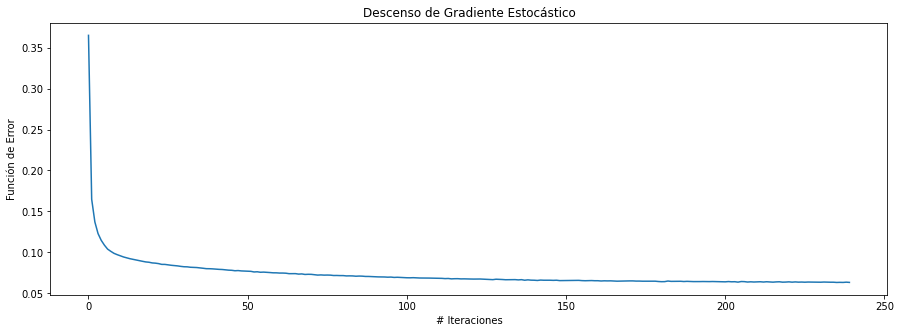

In [29]:
plt.figure(figsize=(15,5))
plt.plot(errores)
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico')

## Seleccion de parametros

In [30]:
def train_linear_regression(X_train, y_train, learning_rate, eps):
    X_train_array = np.c_[np.ones(X_train.values.shape[0]), X_train.values]
    y_train_array = y_train.values
    w0 = np.random.rand(X_train_array.shape[1], 1)
    w = w0.copy()
    errores = list()
    diff_norm = float('inf')
    old_w = w.copy()
    while diff_norm>eps:
      # Ordenamos las muestras de manera aleatoria.
      train_index = list(range(0, X_train_array.shape[0]-1))
      random.shuffle(train_index)
      y_pred = list()
      y_target = list()
      # Iteramos sobre la muestras.
      for i in train_index:
        # Actualizamos los pesos de acuerdo al algoritmo.
          xActual = np.expand_dims(X_train_array[i], 1)
          yActual = y_train_array[i]
          g = np.dot(w.T, xActual)
          e = g-yActual
          w = w - learning_rate*e*xActual
          y_pred.append(g[0][0])
          y_target.append(yActual)
      y_pred = np.array(y_pred)
      y_target = np.array(y_target)
      error = mean_squared_error(y_target, y_pred)
      errores.append(error)
      # Computamos la diferencia entre los W nuevos y los antiguos
      diff = old_w-w
      diff_norm = np.sqrt(diff.T.dot(diff))[0][0]
      old_w = w.copy()
    return w, errores

In [31]:
w_exp1, errores_exp1 = train_linear_regression(X_train, y_train, 0.001, 0.01)
w_exp2, errores_exp2 = train_linear_regression(X_train, y_train, 0.01, 0.08)
w_exp3, errores_exp3 = train_linear_regression(X_train, y_train, 0.0001, 0.0050)

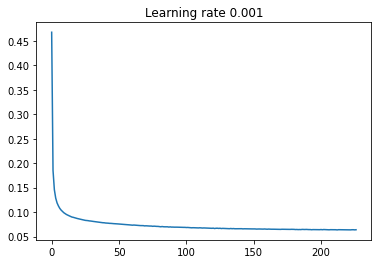

In [32]:
plt.plot(errores_exp1)
plt.title(f"Learning rate {0.001}")
plt.show()

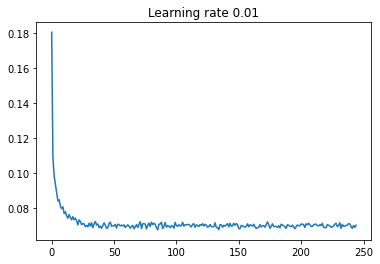

In [33]:
plt.plot(errores_exp2)
plt.title(f"Learning rate {0.01}")
plt.show()

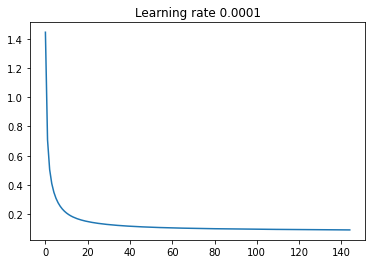

In [34]:
plt.plot(errores_exp3)
plt.title(f"Learning rate {0.0001}")
plt.show()

In [35]:
def test_model(model, X_train, X_test, y_train, y_test):
  y_train_array = y_train.values
  y_test_array = y_test.values
  y_train_preds = np.zeros(y_train_array.shape)
  for i in range(X_train_array.shape[0]):
      y_train_preds[i] = np.dot(model.T,X_train_array[i])

  y_test_preds = np.zeros(y_test_array.shape)
  for i in range(X_test_array.shape[0]):
      y_test_preds[i] = np.dot(model.T,X_test_array[i])
      
  r2_train = r2_score(y_train_array, y_train_preds)
  r2_test = r2_score(y_test_array, y_test_preds)
  print(f'R2 entrenamiento: {round(r2_train,4)}\nR2 prueba: {round(r2_test,4)}')

## Resultados modelo learning rate 0.001

In [36]:
test_model(w_exp1, X_train, X_test, y_train, y_test)

R2 entrenamiento: 0.9285
R2 prueba: 0.9143


## Resultados modelo learning rate 0.01

In [37]:
test_model(w_exp2, X_train, X_test, y_train, y_test)

R2 entrenamiento: 0.9246
R2 prueba: 0.911


## Resultados modelo learning rate 0.0001

In [38]:
test_model(w_exp3, X_train, X_test, y_train, y_test)

R2 entrenamiento: 0.8964
R2 prueba: 0.8939


Para la seleccion de modelo probamos con diferentes valores de la tasa de aprendizaje, como se puede ver en las _learning curves_ anteriores,  el learning rate mas alto (0.01) tiene un comportamineto "ruidoso" esto puede deberse a que es un valor muy alto y el algoritmo oscila sobre el minimo pero jamas logra acercarce tanto comos los modelos que usan pasos menores. Por otro lado, al comparar las curvas de aprendizaje para los learning rate 0.001, 0.0001 es evidente que el tamaño del paso afecta al velocidad de convergencia.

Sin embargo, los resultados en los datos de pruebas de los tres modelos son bastante similares y las diferencias en la tasa de aprendizaje para este caso no ayudan de manera signifcativa al desempeño de los modelos.

# Conclusiones

* El acondicionamiento de los datos es muy importante para obtener buenos resultados, donde se pudo evidenciar que con un mismo modelo puede variar el valor de las métricas de acuerdo con el tipo de scaler y de codificación.  

* Aunque con este grupo de datos la variación de métricas es pequeña al variar la cantidad de datos de entrenamiento, a nivel general, entrenar con mayor cantidad de datos es deseable para reducir el sobreajuste de los datos.

* La codificación por medio de one hot amplía el número de variables de entrenamiento, se podría pensar que esto afecta negativamente a los entrenamientos al ampliar su complejidad o dimensionalidad en cuanto a variables, sin embargo, los resultados obtenidos nos dicen que es mucho más facil para un modelo de regresión lineal obtener un mejor modelo de esta forma que manteniendo el número de variables pero convirtiendo las categóricas en númericas, como funciona con la codificación ordinal.

* El scaler MinMax y Robust pueden funcionar mejor uno u otro dependiendo de los datos y del problema a solucionar, el Robust modifica la distribución de los datos, eliminando outlayers, por ende puede funcionar mejor ante datos con esta característica, sin embargo, el MinMax demostró ser el mejor en la codificaión ordinal en la métrica RMSE, por ende se podría concluir que la data empleada se encontraba libre de outlayers y que ante datos no muy complejos el MinMax tiene mucho mejor resultado frente al Robust.


* La implementación de descenso de gradiente estocástico fue realizada empleando como criterio de parada la diferencia entre dos vectores de pesos consecutivos, nuestra implementación del algoritmo obtiene resultados tan buenos como los que se obtienen por medio de la librería Scikit-Learn, ya que el R2 obtenido para test en ambos casos es 0.917, donde, como se observa en la gráfica, se logra una convergencia del error muy buena y rápida, ya que en las primeras 20 iteraciones se logra una reducción del error muy significativa y esta continúa descendiendo en el tiempo hasta lograr cumplir con el criterio de parada. 

* Al cambiar la tasa de aprendizaje tambien es necesario cambiar el criterio de parada puesto en algunos casos no se logra convergencia en un tiempo de entrenamiento razonable o en ocaciones la magnitud 

# Referencias

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

https://www.kaggle.com/discdiver/guide-to-scaling-and-standardizing